In [1]:
from collections import Counter
from typing import Any

import numpy as np
import optuna
from imblearn.datasets import make_imbalance
from sklearn.datasets import make_classification
from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)

from estimator.xgboost import IMMAXClassifier, XGBClassifier
from metrics.visualize import plot_confusion_matrix

/home/ubuntu/projects/research/balancing_the_scales/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED: int = 1234
N_SPLITS: int = 5

In [3]:
def ratio_multiplier(
    y: np.ndarray,
    multipliers: dict,
) -> Counter[Any]:
    target_stats = Counter(y)
    for key, value in target_stats.items():
        target_stats[key] = int(value * multipliers[key])
    return target_stats

In [4]:
X, y = make_classification(
    n_samples=1000000,
    n_features=30,
    n_redundant=0,
    n_clusters_per_class=1,
    shuffle=True,
    weights=[0.95],
    flip_y=0.3,  # 30%ラベルを入れ替え
    random_state=SEED,
)
X_imb, y_imb = make_imbalance(
    X,
    y,
    sampling_strategy=ratio_multiplier,
    random_state=SEED,
    multipliers={0: 1, 1: 0.06},
)
print(f'X shape ({X.shape}) ==> X_imb shape ({X_imb.shape})')
print(f'y ratio ({(y == 1).sum() / len(y):.2%}) ==> y_imb ratio ({(y_imb == 1).sum() / len(y_imb):.2%})')

X shape ((1000000, 30)) ==> X_imb shape ((826435, 30))
y ratio (18.46%) ==> y_imb ratio (1.34%)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_imb,
    y_imb,
    stratify=y_imb,
    test_size=0.2,
    random_state=SEED,
)

In [6]:
base_params: dict[str, int | float | str] = {
    'max_depth': 3,
    'min_child_weight': 1,
    'seed': SEED,
    'eval_metric': 'logloss',
    'objective': 'binary:logistic',
    'learning_rate': 0.1,
}

In [7]:
m_pos = np.sum(y_train == 1)
m_neg = np.sum(y_train == 0)

rho_pos = m_pos ** (1 / 3)
rho_neg = m_neg ** (1 / 3)
alpha = rho_pos / (rho_pos + rho_neg)

print(f'alpha = {alpha:.4f} (rho_pos={rho_pos:.2f}, rho_neg={rho_neg:.2f})')

alpha = 0.1926 (rho_pos=20.69, rho_neg=86.73)


In [8]:
normal_rho_pos = np.random.normal(rho_pos, size=10, scale=6)
normal_rho_neg = np.random.normal(rho_neg, size=10, scale=6)

In [9]:
cv = StratifiedKFold(
    n_splits=N_SPLITS,
    shuffle=True,
    random_state=SEED,
)

In [10]:
def optimize_params_with_optuna(X, y, n_trials: int = 10) -> optuna.Study:
    """Optunaでparams内のパラメータを最適化"""

    def objective(trial):
        # IMMAXパラメータ
        rho_plus = trial.suggest_float('rho_plus', normal_rho_pos.min(), normal_rho_pos.max())
        rho_minus = trial.suggest_float('rho_minus', normal_rho_neg.min(), normal_rho_neg.max())

        # params内のXGBoostパラメータ
        subsample = trial.suggest_float('subsample', 0.6, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
        reg_lambda = trial.suggest_float('reg_lambda', 1.0, 5.0)

        # paramsを構築
        tuning_params = {
            'max_depth': 3,
            'learning_rate': 0.1,
            'min_child_weight': 1,
            'subsample': subsample,
            'colsample_bytree': colsample_bytree,
            'reg_lambda': reg_lambda,
            'disable_default_eval_metric': 1,
            'eval_metric': 'logloss',
            'objective': 'binary:logistic',
        }

        # モデル作成
        model = IMMAXClassifier(
            rho_plus=rho_plus,
            rho_minus=rho_minus,
            params=tuning_params,
        )

        # クロスバリデーション
        scores = cross_val_score(model, X, y, cv=cv)
        return scores.mean()

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    return study

In [11]:
# 実行
study = optimize_params_with_optuna(X_train, y_train, n_trials=20)
print('Best parameters:', study.best_params)
print('Best score:', study.best_value)

[I 2025-09-21 14:49:08,447] A new study created in memory with name: no-name-de023cb1-98d9-4d06-8d7f-993664781231


[0]	train-logloss:0.14981	train-immax_logloss:0.63839	valid-logloss:0.15428	valid-immax_logloss:0.63850
[1000]	train-logloss:0.49238	train-immax_logloss:0.17520	valid-logloss:0.50708	valid-immax_logloss:0.17876
[2000]	train-logloss:0.49238	train-immax_logloss:0.17344	valid-logloss:0.50708	valid-immax_logloss:0.17654
[2601]	train-logloss:0.49227	train-immax_logloss:0.17328	valid-logloss:0.50706	valid-immax_logloss:0.17643
[0]	train-logloss:0.15007	train-immax_logloss:0.63830	valid-logloss:0.15434	valid-immax_logloss:0.63841
[1000]	train-logloss:0.49238	train-immax_logloss:0.17457	valid-logloss:0.50638	valid-immax_logloss:0.17912
[2000]	train-logloss:0.49238	train-immax_logloss:0.17275	valid-logloss:0.50638	valid-immax_logloss:0.17783
[2246]	train-logloss:0.49238	train-immax_logloss:0.17266	valid-logloss:0.50638	valid-immax_logloss:0.17780
[0]	train-logloss:0.15051	train-immax_logloss:0.63836	valid-logloss:0.14911	valid-immax_logloss:0.63832
[1000]	train-logloss:0.49424	train-immax_loglo

[I 2025-09-21 15:13:19,329] Trial 0 finished with value: 0.9865960420449408 and parameters: {'rho_plus': 27.45524608352766, 'rho_minus': 92.83903881807281, 'subsample': 0.8478174574820401, 'colsample_bytree': 0.6464623299512603, 'reg_lambda': 4.893998191372569}. Best is trial 0 with value: 0.9865960420449408.


[0]	train-logloss:0.14958	train-immax_logloss:0.62416	valid-logloss:0.15141	valid-immax_logloss:0.62421
[1000]	train-logloss:0.47274	train-immax_logloss:0.15662	valid-logloss:0.48338	valid-immax_logloss:0.15941
[1019]	train-logloss:0.47217	train-immax_logloss:0.15661	valid-logloss:0.48265	valid-immax_logloss:0.15942
[0]	train-logloss:0.14905	train-immax_logloss:0.62408	valid-logloss:0.15116	valid-immax_logloss:0.62421
[905]	train-logloss:0.46984	train-immax_logloss:0.15609	valid-logloss:0.48572	valid-immax_logloss:0.16028
[0]	train-logloss:0.15028	train-immax_logloss:0.62416	valid-logloss:0.14768	valid-immax_logloss:0.62410
[1000]	train-logloss:0.47565	train-immax_logloss:0.15724	valid-logloss:0.46862	valid-immax_logloss:0.15512
[1053]	train-logloss:0.47457	train-immax_logloss:0.15722	valid-logloss:0.46730	valid-immax_logloss:0.15514
[0]	train-logloss:0.15021	train-immax_logloss:0.62424	valid-logloss:0.15084	valid-immax_logloss:0.62426
[907]	train-logloss:0.47538	train-immax_logloss:0.

[I 2025-09-21 15:22:12,864] Trial 1 finished with value: 0.9865930170127998 and parameters: {'rho_plus': 28.507106943896897, 'rho_minus': 87.22246233747371, 'subsample': 0.9439432096785275, 'colsample_bytree': 0.7546754226121238, 'reg_lambda': 1.888685254147445}. Best is trial 0 with value: 0.9865960420449408.


[0]	train-logloss:0.12703	train-immax_logloss:0.63684	valid-logloss:0.12802	valid-immax_logloss:0.63685
[898]	train-logloss:0.43987	train-immax_logloss:0.20064	valid-logloss:0.44766	valid-immax_logloss:0.20361
[0]	train-logloss:0.12685	train-immax_logloss:0.63679	valid-logloss:0.12870	valid-immax_logloss:0.63691
[778]	train-logloss:0.43665	train-immax_logloss:0.19998	valid-logloss:0.45216	valid-immax_logloss:0.20444
[0]	train-logloss:0.12776	train-immax_logloss:0.63695	valid-logloss:0.12587	valid-immax_logloss:0.63689
[919]	train-logloss:0.44213	train-immax_logloss:0.20141	valid-logloss:0.43111	valid-immax_logloss:0.19890
[0]	train-logloss:0.12752	train-immax_logloss:0.63696	valid-logloss:0.12808	valid-immax_logloss:0.63701
[907]	train-logloss:0.44071	train-immax_logloss:0.20130	valid-logloss:0.44213	valid-immax_logloss:0.20131
[0]	train-logloss:0.12724	train-immax_logloss:0.63701	valid-logloss:0.12482	valid-immax_logloss:0.63691
[879]	train-logloss:0.43763	train-immax_logloss:0.20111	

[I 2025-09-21 15:30:06,175] Trial 2 finished with value: 0.9853875382044096 and parameters: {'rho_plus': 19.469927251865744, 'rho_minus': 85.31744830383289, 'subsample': 0.6671190786653242, 'colsample_bytree': 0.6571794429133044, 'reg_lambda': 2.852286662383881}. Best is trial 0 with value: 0.9865960420449408.


[0]	train-logloss:0.12482	train-immax_logloss:0.63895	valid-logloss:0.12500	valid-immax_logloss:0.63897
[1000]	train-logloss:0.45436	train-immax_logloss:0.20379	valid-logloss:0.46121	valid-immax_logloss:0.20575
[1168]	train-logloss:0.45952	train-immax_logloss:0.20364	valid-logloss:0.46633	valid-immax_logloss:0.20574
[0]	train-logloss:0.12455	train-immax_logloss:0.63882	valid-logloss:0.12621	valid-immax_logloss:0.63889
[851]	train-logloss:0.45110	train-immax_logloss:0.20334	valid-logloss:0.46547	valid-immax_logloss:0.20614
[0]	train-logloss:0.12523	train-immax_logloss:0.63888	valid-logloss:0.12407	valid-immax_logloss:0.63882
[1000]	train-logloss:0.45428	train-immax_logloss:0.20445	valid-logloss:0.44780	valid-immax_logloss:0.20250
[2000]	train-logloss:0.47941	train-immax_logloss:0.20377	valid-logloss:0.46924	valid-immax_logloss:0.20227
[2149]	train-logloss:0.48090	train-immax_logloss:0.20369	valid-logloss:0.47120	valid-immax_logloss:0.20227
[0]	train-logloss:0.12477	train-immax_logloss:0

[I 2025-09-21 15:44:45,498] Trial 3 finished with value: 0.9827512147094071 and parameters: {'rho_plus': 18.637508924012536, 'rho_minus': 85.59653541893397, 'subsample': 0.9602437891743736, 'colsample_bytree': 0.7337174471287518, 'reg_lambda': 4.735027770675932}. Best is trial 0 with value: 0.9865960420449408.


[0]	train-logloss:0.12890	train-immax_logloss:0.63941	valid-logloss:0.12907	valid-immax_logloss:0.63943
[699]	train-logloss:0.45164	train-immax_logloss:0.20162	valid-logloss:0.45840	valid-immax_logloss:0.20287
[0]	train-logloss:0.12858	train-immax_logloss:0.63929	valid-logloss:0.13029	valid-immax_logloss:0.63936
[592]	train-logloss:0.45041	train-immax_logloss:0.20093	valid-logloss:0.46457	valid-immax_logloss:0.20396
[0]	train-logloss:0.12924	train-immax_logloss:0.63936	valid-logloss:0.12806	valid-immax_logloss:0.63931
[739]	train-logloss:0.45250	train-immax_logloss:0.20218	valid-logloss:0.44475	valid-immax_logloss:0.20015
[0]	train-logloss:0.12887	train-immax_logloss:0.63940	valid-logloss:0.12966	valid-immax_logloss:0.63944
[916]	train-logloss:0.45836	train-immax_logloss:0.20195	valid-logloss:0.46037	valid-immax_logloss:0.20314
[0]	train-logloss:0.12909	train-immax_logloss:0.63936	valid-logloss:0.12694	valid-immax_logloss:0.63930
[730]	train-logloss:0.46097	train-immax_logloss:0.20167	

[I 2025-09-21 15:51:40,595] Trial 4 finished with value: 0.982725501901893 and parameters: {'rho_plus': 19.994006197828153, 'rho_minus': 89.67723552728009, 'subsample': 0.9716999749126637, 'colsample_bytree': 0.9417465061859448, 'reg_lambda': 4.778577030854151}. Best is trial 0 with value: 0.9865960420449408.


[0]	train-logloss:0.12435	train-immax_logloss:0.63489	valid-logloss:0.12476	valid-immax_logloss:0.63491
[284]	train-logloss:0.43164	train-immax_logloss:0.20619	valid-logloss:0.44018	valid-immax_logloss:0.20745
[0]	train-logloss:0.12433	train-immax_logloss:0.63476	valid-logloss:0.12561	valid-immax_logloss:0.63484
[274]	train-logloss:0.43445	train-immax_logloss:0.20546	valid-logloss:0.44866	valid-immax_logloss:0.20833
[0]	train-logloss:0.12495	train-immax_logloss:0.63504	valid-logloss:0.12215	valid-immax_logloss:0.63492
[358]	train-logloss:0.43696	train-immax_logloss:0.20674	valid-logloss:0.42610	valid-immax_logloss:0.20405
[0]	train-logloss:0.12469	train-immax_logloss:0.63493	valid-logloss:0.12518	valid-immax_logloss:0.63496
[952]	train-logloss:0.46718	train-immax_logloss:0.20605	valid-logloss:0.46767	valid-immax_logloss:0.20726
[0]	train-logloss:0.12430	train-immax_logloss:0.63511	valid-logloss:0.12249	valid-immax_logloss:0.63504
[629]	train-logloss:0.45270	train-immax_logloss:0.20594	

[I 2025-09-21 15:56:15,152] Trial 5 finished with value: 0.9829130547639673 and parameters: {'rho_plus': 17.30248988370836, 'rho_minus': 79.87275860879187, 'subsample': 0.686855863414259, 'colsample_bytree': 0.9941677094541775, 'reg_lambda': 2.4510517013349777}. Best is trial 0 with value: 0.9865960420449408.


[0]	train-logloss:0.17479	train-immax_logloss:0.62647	valid-logloss:0.18001	valid-immax_logloss:0.62660
[1000]	train-logloss:0.47814	train-immax_logloss:0.15831	valid-logloss:0.49017	valid-immax_logloss:0.16113
[1331]	train-logloss:0.46873	train-immax_logloss:0.15819	valid-logloss:0.47849	valid-immax_logloss:0.16111
[0]	train-logloss:0.17489	train-immax_logloss:0.62643	valid-logloss:0.17987	valid-immax_logloss:0.62655
[971]	train-logloss:0.47238	train-immax_logloss:0.15773	valid-logloss:0.48800	valid-immax_logloss:0.16193
[0]	train-logloss:0.17547	train-immax_logloss:0.62647	valid-logloss:0.17385	valid-immax_logloss:0.62643
[1000]	train-logloss:0.48066	train-immax_logloss:0.15898	valid-logloss:0.47453	valid-immax_logloss:0.15679
[1157]	train-logloss:0.47576	train-immax_logloss:0.15890	valid-logloss:0.46875	valid-immax_logloss:0.15679
[0]	train-logloss:0.17514	train-immax_logloss:0.62652	valid-logloss:0.17569	valid-immax_logloss:0.62653
[1000]	train-logloss:0.47664	train-immax_logloss:0

[I 2025-09-21 16:05:29,329] Trial 6 finished with value: 0.9865854544324474 and parameters: {'rho_plus': 28.60020984804401, 'rho_minus': 88.6664854663664, 'subsample': 0.9654255625274157, 'colsample_bytree': 0.808901293211544, 'reg_lambda': 2.428341525319055}. Best is trial 0 with value: 0.9865960420449408.


[0]	train-logloss:0.16331	train-immax_logloss:0.62622	valid-logloss:0.16819	valid-immax_logloss:0.62636
[195]	train-logloss:0.49238	train-immax_logloss:0.17294	valid-logloss:0.50708	valid-immax_logloss:0.17674
[0]	train-logloss:0.16339	train-immax_logloss:0.62619	valid-logloss:0.16804	valid-immax_logloss:0.62632
[197]	train-logloss:0.49238	train-immax_logloss:0.17292	valid-logloss:0.50638	valid-immax_logloss:0.17641
[0]	train-logloss:0.16369	train-immax_logloss:0.62633	valid-logloss:0.16218	valid-immax_logloss:0.62629
[248]	train-logloss:0.49424	train-immax_logloss:0.17348	valid-logloss:0.48967	valid-immax_logloss:0.17214
[0]	train-logloss:0.16374	train-immax_logloss:0.62624	valid-logloss:0.16425	valid-immax_logloss:0.62625
[220]	train-logloss:0.49369	train-immax_logloss:0.17325	valid-logloss:0.49524	valid-immax_logloss:0.17386
[0]	train-logloss:0.16392	train-immax_logloss:0.62645	valid-logloss:0.15778	valid-immax_logloss:0.62628
[375]	train-logloss:0.49570	train-immax_logloss:0.17398	

[I 2025-09-21 16:07:07,290] Trial 7 finished with value: 0.9865960420449408 and parameters: {'rho_plus': 25.984270982682396, 'rho_minus': 82.41440708398899, 'subsample': 0.6440709682524018, 'colsample_bytree': 0.6798703867850738, 'reg_lambda': 1.7185671470556314}. Best is trial 0 with value: 0.9865960420449408.


[0]	train-logloss:0.13667	train-immax_logloss:0.63821	valid-logloss:0.13844	valid-immax_logloss:0.63828
[844]	train-logloss:0.46574	train-immax_logloss:0.20997	valid-logloss:0.47588	valid-immax_logloss:0.21333
[0]	train-logloss:0.13647	train-immax_logloss:0.63811	valid-logloss:0.13819	valid-immax_logloss:0.63822
[778]	train-logloss:0.46036	train-immax_logloss:0.20896	valid-logloss:0.47594	valid-immax_logloss:0.21363
[0]	train-logloss:0.13730	train-immax_logloss:0.63833	valid-logloss:0.13508	valid-immax_logloss:0.63827
[914]	train-logloss:0.46596	train-immax_logloss:0.21099	valid-logloss:0.45789	valid-immax_logloss:0.20850
[0]	train-logloss:0.13722	train-immax_logloss:0.63831	valid-logloss:0.13774	valid-immax_logloss:0.63833
[811]	train-logloss:0.46635	train-immax_logloss:0.21088	valid-logloss:0.46946	valid-immax_logloss:0.21194
[0]	train-logloss:0.13668	train-immax_logloss:0.63835	valid-logloss:0.13519	valid-immax_logloss:0.63828
[730]	train-logloss:0.46437	train-immax_logloss:0.20977	

[I 2025-09-21 16:14:30,610] Trial 8 finished with value: 0.9859532218456509 and parameters: {'rho_plus': 20.884154693147202, 'rho_minus': 95.4890056265567, 'subsample': 0.6842156136585303, 'colsample_bytree': 0.8829286555933922, 'reg_lambda': 2.2833433270800847}. Best is trial 0 with value: 0.9865960420449408.


[0]	train-logloss:0.17099	train-immax_logloss:0.63017	valid-logloss:0.17610	valid-immax_logloss:0.63031
[189]	train-logloss:0.49238	train-immax_logloss:0.19173	valid-logloss:0.50708	valid-immax_logloss:0.19594
[0]	train-logloss:0.17112	train-immax_logloss:0.63012	valid-logloss:0.17599	valid-immax_logloss:0.63026
[191]	train-logloss:0.49238	train-immax_logloss:0.19166	valid-logloss:0.50638	valid-immax_logloss:0.19563
[0]	train-logloss:0.17127	train-immax_logloss:0.63031	valid-logloss:0.16969	valid-immax_logloss:0.63027
[251]	train-logloss:0.49424	train-immax_logloss:0.19213	valid-logloss:0.48967	valid-immax_logloss:0.19080
[0]	train-logloss:0.17161	train-immax_logloss:0.63013	valid-logloss:0.17215	valid-immax_logloss:0.63014
[219]	train-logloss:0.49369	train-immax_logloss:0.19210	valid-logloss:0.49524	valid-immax_logloss:0.19274
[0]	train-logloss:0.17158	train-immax_logloss:0.63040	valid-logloss:0.16515	valid-immax_logloss:0.63022
[251]	train-logloss:0.49570	train-immax_logloss:0.19279	

[I 2025-09-21 16:16:10,444] Trial 9 finished with value: 0.9865960420449408 and parameters: {'rho_plus': 25.290555522872044, 'rho_minus': 91.19751393812793, 'subsample': 0.6151134645121976, 'colsample_bytree': 0.9271215477355028, 'reg_lambda': 1.5493517432633634}. Best is trial 0 with value: 0.9865960420449408.


[0]	train-logloss:0.13520	train-immax_logloss:0.63787	valid-logloss:0.13647	valid-immax_logloss:0.63791
[1000]	train-logloss:0.47357	train-immax_logloss:0.18968	valid-logloss:0.48524	valid-immax_logloss:0.19292
[1496]	train-logloss:0.45063	train-immax_logloss:0.18936	valid-logloss:0.45812	valid-immax_logloss:0.19273
[0]	train-logloss:0.13492	train-immax_logloss:0.63772	valid-logloss:0.13671	valid-immax_logloss:0.63783
[1000]	train-logloss:0.46664	train-immax_logloss:0.18895	valid-logloss:0.48193	valid-immax_logloss:0.19343
[1311]	train-logloss:0.44899	train-immax_logloss:0.18871	valid-logloss:0.46508	valid-immax_logloss:0.19340
[0]	train-logloss:0.13607	train-immax_logloss:0.63779	valid-logloss:0.13373	valid-immax_logloss:0.63772
[1000]	train-logloss:0.47746	train-immax_logloss:0.19050	valid-logloss:0.47093	valid-immax_logloss:0.18814
[1323]	train-logloss:0.45642	train-immax_logloss:0.19021	valid-logloss:0.44746	valid-immax_logloss:0.18788
[0]	train-logloss:0.13596	train-immax_logloss:

[I 2025-09-21 16:29:07,553] Trial 10 finished with value: 0.9858458317061884 and parameters: {'rho_plus': 23.543790735666676, 'rho_minus': 93.99389350473086, 'subsample': 0.8340036155243981, 'colsample_bytree': 0.6190027985165393, 'reg_lambda': 3.6285841122709934}. Best is trial 0 with value: 0.9865960420449408.


[0]	train-logloss:0.14695	train-immax_logloss:0.62161	valid-logloss:0.14895	valid-immax_logloss:0.62168
[712]	train-logloss:0.46526	train-immax_logloss:0.15940	valid-logloss:0.47478	valid-immax_logloss:0.16215
[0]	train-logloss:0.14644	train-immax_logloss:0.62152	valid-logloss:0.14865	valid-immax_logloss:0.62166
[627]	train-logloss:0.46231	train-immax_logloss:0.15847	valid-logloss:0.47806	valid-immax_logloss:0.16232
[0]	train-logloss:0.14760	train-immax_logloss:0.62162	valid-logloss:0.14512	valid-immax_logloss:0.62156
[688]	train-logloss:0.46840	train-immax_logloss:0.15981	valid-logloss:0.46050	valid-immax_logloss:0.15776
[0]	train-logloss:0.14752	train-immax_logloss:0.62169	valid-logloss:0.14813	valid-immax_logloss:0.62172
[738]	train-logloss:0.46671	train-immax_logloss:0.16001	valid-logloss:0.47044	valid-immax_logloss:0.16014
[0]	train-logloss:0.14684	train-immax_logloss:0.62164	valid-logloss:0.14441	valid-immax_logloss:0.62153
[729]	train-logloss:0.46286	train-immax_logloss:0.15941	

[I 2025-09-21 16:35:49,119] Trial 11 finished with value: 0.986593017001361 and parameters: {'rho_plus': 25.97643363659424, 'rho_minus': 81.97711862636869, 'subsample': 0.8042443615128999, 'colsample_bytree': 0.6735696071841886, 'reg_lambda': 1.0978146007830798}. Best is trial 0 with value: 0.9865960420449408.


[0]	train-logloss:0.14767	train-immax_logloss:0.62785	valid-logloss:0.15208	valid-immax_logloss:0.62797
[1000]	train-logloss:0.48847	train-immax_logloss:0.14997	valid-logloss:0.50292	valid-immax_logloss:0.15229
[1528]	train-logloss:0.46175	train-immax_logloss:0.14963	valid-logloss:0.47156	valid-immax_logloss:0.15197
[0]	train-logloss:0.14784	train-immax_logloss:0.62778	valid-logloss:0.15205	valid-immax_logloss:0.62789
[1000]	train-logloss:0.47755	train-immax_logloss:0.14886	valid-logloss:0.49243	valid-immax_logloss:0.15250
[1316]	train-logloss:0.45943	train-immax_logloss:0.14863	valid-logloss:0.47511	valid-immax_logloss:0.15250
[0]	train-logloss:0.14833	train-immax_logloss:0.62782	valid-logloss:0.14696	valid-immax_logloss:0.62778
[1000]	train-logloss:0.49166	train-immax_logloss:0.15052	valid-logloss:0.48716	valid-immax_logloss:0.14828
[1518]	train-logloss:0.46554	train-immax_logloss:0.15016	valid-logloss:0.45831	valid-immax_logloss:0.14803
[0]	train-logloss:0.14803	train-immax_logloss:

[I 2025-09-21 16:48:57,189] Trial 12 finished with value: 0.986567304228163 and parameters: {'rho_plus': 26.42804722850809, 'rho_minus': 76.84201182745673, 'subsample': 0.8681520661241835, 'colsample_bytree': 0.6106314612824398, 'reg_lambda': 3.802786644282569}. Best is trial 0 with value: 0.9865960420449408.


[0]	train-logloss:0.14398	train-immax_logloss:0.63441	valid-logloss:0.14827	valid-immax_logloss:0.63454
[1000]	train-logloss:0.48323	train-immax_logloss:0.17500	valid-logloss:0.49620	valid-immax_logloss:0.17810
[1538]	train-logloss:0.45684	train-immax_logloss:0.17459	valid-logloss:0.46483	valid-immax_logloss:0.17783
[0]	train-logloss:0.12623	train-immax_logloss:0.63423	valid-logloss:0.12794	valid-immax_logloss:0.63435
[1000]	train-logloss:0.46993	train-immax_logloss:0.17359	valid-logloss:0.48526	valid-immax_logloss:0.17800
[1269]	train-logloss:0.45512	train-immax_logloss:0.17336	valid-logloss:0.47126	valid-immax_logloss:0.17794
[0]	train-logloss:0.12762	train-immax_logloss:0.63417	valid-logloss:0.12580	valid-immax_logloss:0.63414
[1000]	train-logloss:0.48165	train-immax_logloss:0.17528	valid-logloss:0.47544	valid-immax_logloss:0.17295
[1396]	train-logloss:0.46134	train-immax_logloss:0.17495	valid-logloss:0.45275	valid-immax_logloss:0.17277
[0]	train-logloss:0.12710	train-immax_logloss:

[I 2025-09-21 17:01:29,154] Trial 13 finished with value: 0.9863449638968188 and parameters: {'rho_plus': 23.3147651938373, 'rho_minus': 82.68014890672785, 'subsample': 0.7438183418489941, 'colsample_bytree': 0.7298522937438523, 'reg_lambda': 3.706755578674356}. Best is trial 0 with value: 0.9865960420449408.


[0]	train-logloss:0.15628	train-immax_logloss:0.63541	valid-logloss:0.16095	valid-immax_logloss:0.63553
[1000]	train-logloss:0.49238	train-immax_logloss:0.17231	valid-logloss:0.50708	valid-immax_logloss:0.17569
[1812]	train-logloss:0.48504	train-immax_logloss:0.17107	valid-logloss:0.49817	valid-immax_logloss:0.17442
[0]	train-logloss:0.15655	train-immax_logloss:0.63532	valid-logloss:0.16101	valid-immax_logloss:0.63543
[1000]	train-logloss:0.49238	train-immax_logloss:0.17182	valid-logloss:0.50638	valid-immax_logloss:0.17613
[1690]	train-logloss:0.48233	train-immax_logloss:0.17059	valid-logloss:0.49694	valid-immax_logloss:0.17525
[0]	train-logloss:0.15702	train-immax_logloss:0.63538	valid-logloss:0.15557	valid-immax_logloss:0.63534
[1000]	train-logloss:0.49424	train-immax_logloss:0.17317	valid-logloss:0.48967	valid-immax_logloss:0.17125
[1869]	train-logloss:0.48652	train-immax_logloss:0.17184	valid-logloss:0.48109	valid-immax_logloss:0.16969
[0]	train-logloss:0.15661	train-immax_logloss:

[I 2025-09-21 17:18:23,170] Trial 14 finished with value: 0.9865960420449408 and parameters: {'rho_plus': 27.104237840783483, 'rho_minus': 91.6594646313053, 'subsample': 0.8841921223215082, 'colsample_bytree': 0.688072729704619, 'reg_lambda': 4.1960524883656225}. Best is trial 0 with value: 0.9865960420449408.


[0]	train-logloss:0.15122	train-immax_logloss:0.63110	valid-logloss:0.15574	valid-immax_logloss:0.63123
[1000]	train-logloss:0.48517	train-immax_logloss:0.16843	valid-logloss:0.49848	valid-immax_logloss:0.17145
[1372]	train-logloss:0.46915	train-immax_logloss:0.16819	valid-logloss:0.47903	valid-immax_logloss:0.17137
[0]	train-logloss:0.15151	train-immax_logloss:0.63099	valid-logloss:0.15582	valid-immax_logloss:0.63111
[1000]	train-logloss:0.47808	train-immax_logloss:0.16788	valid-logloss:0.49289	valid-immax_logloss:0.17235
[1200]	train-logloss:0.46841	train-immax_logloss:0.16771	valid-logloss:0.48401	valid-immax_logloss:0.17236
[0]	train-logloss:0.15159	train-immax_logloss:0.63120	valid-logloss:0.15019	valid-immax_logloss:0.63116
[1000]	train-logloss:0.48715	train-immax_logloss:0.16915	valid-logloss:0.48191	valid-immax_logloss:0.16695
[1240]	train-logloss:0.47525	train-immax_logloss:0.16895	valid-logloss:0.46816	valid-immax_logloss:0.16686
[0]	train-logloss:0.15141	train-immax_logloss:

[I 2025-09-21 17:29:52,692] Trial 15 finished with value: 0.9865733543153221 and parameters: {'rho_plus': 24.62804362941313, 'rho_minus': 82.33285369313617, 'subsample': 0.7502160766666326, 'colsample_bytree': 0.8022609216000359, 'reg_lambda': 3.086212970723993}. Best is trial 0 with value: 0.9865960420449408.


[0]	train-logloss:0.16752	train-immax_logloss:0.62107	valid-logloss:0.17252	valid-immax_logloss:0.62120
[179]	train-logloss:0.49238	train-immax_logloss:0.16131	valid-logloss:0.50708	valid-immax_logloss:0.16491
[0]	train-logloss:0.16769	train-immax_logloss:0.62100	valid-logloss:0.17246	valid-immax_logloss:0.62113
[183]	train-logloss:0.49238	train-immax_logloss:0.16126	valid-logloss:0.50638	valid-immax_logloss:0.16457
[0]	train-logloss:0.16792	train-immax_logloss:0.62118	valid-logloss:0.16637	valid-immax_logloss:0.62114
[233]	train-logloss:0.49424	train-immax_logloss:0.16187	valid-logloss:0.48967	valid-immax_logloss:0.16065
[0]	train-logloss:0.16804	train-immax_logloss:0.62105	valid-logloss:0.16857	valid-immax_logloss:0.62106
[203]	train-logloss:0.49369	train-immax_logloss:0.16158	valid-logloss:0.49524	valid-immax_logloss:0.16224
[0]	train-logloss:0.16833	train-immax_logloss:0.62123	valid-logloss:0.16202	valid-immax_logloss:0.62106
[251]	train-logloss:0.49570	train-immax_logloss:0.16235	

[I 2025-09-21 17:31:26,860] Trial 16 finished with value: 0.9865960420449408 and parameters: {'rho_plus': 27.27762224674835, 'rho_minus': 78.6378536978865, 'subsample': 0.6014101788284074, 'colsample_bytree': 0.6467184269739914, 'reg_lambda': 1.0483006943472497}. Best is trial 0 with value: 0.9865960420449408.


[0]	train-logloss:0.13533	train-immax_logloss:0.63147	valid-logloss:0.13616	valid-immax_logloss:0.63149
[740]	train-logloss:0.43994	train-immax_logloss:0.18162	valid-logloss:0.44927	valid-immax_logloss:0.18337
[0]	train-logloss:0.13531	train-immax_logloss:0.63131	valid-logloss:0.13694	valid-immax_logloss:0.63141
[623]	train-logloss:0.44342	train-immax_logloss:0.18107	valid-logloss:0.46012	valid-immax_logloss:0.18438
[0]	train-logloss:0.13618	train-immax_logloss:0.63140	valid-logloss:0.13326	valid-immax_logloss:0.63132
[722]	train-logloss:0.44118	train-immax_logloss:0.18213	valid-logloss:0.42911	valid-immax_logloss:0.17943
[0]	train-logloss:0.13585	train-immax_logloss:0.63152	valid-logloss:0.13583	valid-immax_logloss:0.63154
[766]	train-logloss:0.44305	train-immax_logloss:0.18212	valid-logloss:0.44440	valid-immax_logloss:0.18206
[0]	train-logloss:0.13579	train-immax_logloss:0.63141	valid-logloss:0.13303	valid-immax_logloss:0.63132
[734]	train-logloss:0.44438	train-immax_logloss:0.18182	

[I 2025-09-21 17:38:09,960] Trial 17 finished with value: 0.9840882828162805 and parameters: {'rho_plus': 21.87606722029585, 'rho_minus': 84.66676407574315, 'subsample': 0.8979665903211915, 'colsample_bytree': 0.7065191196636315, 'reg_lambda': 3.001959029860548}. Best is trial 0 with value: 0.9865960420449408.


[0]	train-logloss:0.14630	train-immax_logloss:0.63976	valid-logloss:0.15067	valid-immax_logloss:0.63988
[297]	train-logloss:0.49238	train-immax_logloss:0.19390	valid-logloss:0.50708	valid-immax_logloss:0.19801
[0]	train-logloss:0.14657	train-immax_logloss:0.63967	valid-logloss:0.15074	valid-immax_logloss:0.63979
[293]	train-logloss:0.49238	train-immax_logloss:0.19380	valid-logloss:0.50638	valid-immax_logloss:0.19774
[0]	train-logloss:0.14660	train-immax_logloss:0.63987	valid-logloss:0.14525	valid-immax_logloss:0.63983
[390]	train-logloss:0.49424	train-immax_logloss:0.19439	valid-logloss:0.48967	valid-immax_logloss:0.19281
[0]	train-logloss:0.14645	train-immax_logloss:0.63986	valid-logloss:0.14691	valid-immax_logloss:0.63987
[333]	train-logloss:0.49369	train-immax_logloss:0.19423	valid-logloss:0.49524	valid-immax_logloss:0.19490
[0]	train-logloss:0.14689	train-immax_logloss:0.63993	valid-logloss:0.14139	valid-immax_logloss:0.63978
[415]	train-logloss:0.49570	train-immax_logloss:0.19466	

[I 2025-09-21 17:41:06,340] Trial 18 finished with value: 0.9865960420449408 and parameters: {'rho_plus': 24.78752653486597, 'rho_minus': 92.48612027062215, 'subsample': 0.7469434851083455, 'colsample_bytree': 0.777026050188664, 'reg_lambda': 4.256832040916539}. Best is trial 0 with value: 0.9865960420449408.


[0]	train-logloss:0.15165	train-immax_logloss:0.62396	valid-logloss:0.15403	valid-immax_logloss:0.62403
[963]	train-logloss:0.48619	train-immax_logloss:0.16218	valid-logloss:0.49976	valid-immax_logloss:0.16520
[0]	train-logloss:0.15130	train-immax_logloss:0.62382	valid-logloss:0.15344	valid-immax_logloss:0.62395
[739]	train-logloss:0.48914	train-immax_logloss:0.16165	valid-logloss:0.50326	valid-immax_logloss:0.16590
[0]	train-logloss:0.15258	train-immax_logloss:0.62387	valid-logloss:0.15013	valid-immax_logloss:0.62381
[863]	train-logloss:0.49107	train-immax_logloss:0.16284	valid-logloss:0.48642	valid-immax_logloss:0.16080
[0]	train-logloss:0.15234	train-immax_logloss:0.62400	valid-logloss:0.15294	valid-immax_logloss:0.62401
[846]	train-logloss:0.49023	train-immax_logloss:0.16283	valid-logloss:0.49249	valid-immax_logloss:0.16334
[0]	train-logloss:0.15176	train-immax_logloss:0.62387	valid-logloss:0.14954	valid-immax_logloss:0.62379
[929]	train-logloss:0.48527	train-immax_logloss:0.16237	

[I 2025-09-21 17:48:01,004] Trial 19 finished with value: 0.9865960420449408 and parameters: {'rho_plus': 27.714425592372898, 'rho_minus': 87.7432150956144, 'subsample': 0.8479512151765536, 'colsample_bytree': 0.8423297365215093, 'reg_lambda': 1.4394099459927676}. Best is trial 0 with value: 0.9865960420449408.


Best parameters: {'rho_plus': 27.45524608352766, 'rho_minus': 92.83903881807281, 'subsample': 0.8478174574820401, 'colsample_bytree': 0.6464623299512603, 'reg_lambda': 4.893998191372569}
Best score: 0.9865960420449408


In [12]:
best_params = base_params | {
    key: value
    for (
        key,
        value,
    ) in study.best_params.items()
    if key not in ['rho_minus', 'rho_plus']
}

In [13]:
clf = IMMAXClassifier(
    rho_plus=study.best_params['rho_plus'],
    rho_minus=study.best_params['rho_minus'],
    params=best_params,
)
clf.fit(X_train, y_train)

[0]	train-logloss:0.15889	train-immax_logloss:0.63540	valid-logloss:0.15825	valid-immax_logloss:0.63538
[1000]	train-logloss:0.49402	train-immax_logloss:0.16848	valid-logloss:0.49204	valid-immax_logloss:0.16942
[1646]	train-logloss:0.45779	train-immax_logloss:0.16764	valid-logloss:0.45736	valid-immax_logloss:0.16889


,params,"{'colsample_bytree': 0.6464623299512603, 'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 3, ...}"
,valid_frac,0.1
,seed,1234
,num_boost_round,10000
,early_stopping_rounds,100
,verbose_eval,1000
,rho_plus,27.45524608352766
,rho_minus,92.83903881807281


In [14]:
y_pred = clf.predict(X_test)

Confusion matrix, without normalization
[[163042     29]
 [  2203     13]]


/home/ubuntu/projects/research/balancing_the_scales/src/metrics/visualize.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tick_marks, fontsize=25)
/home/ubuntu/projects/research/balancing_the_scales/src/metrics/visualize.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(tick_marks, fontsize=25)


<Axes: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

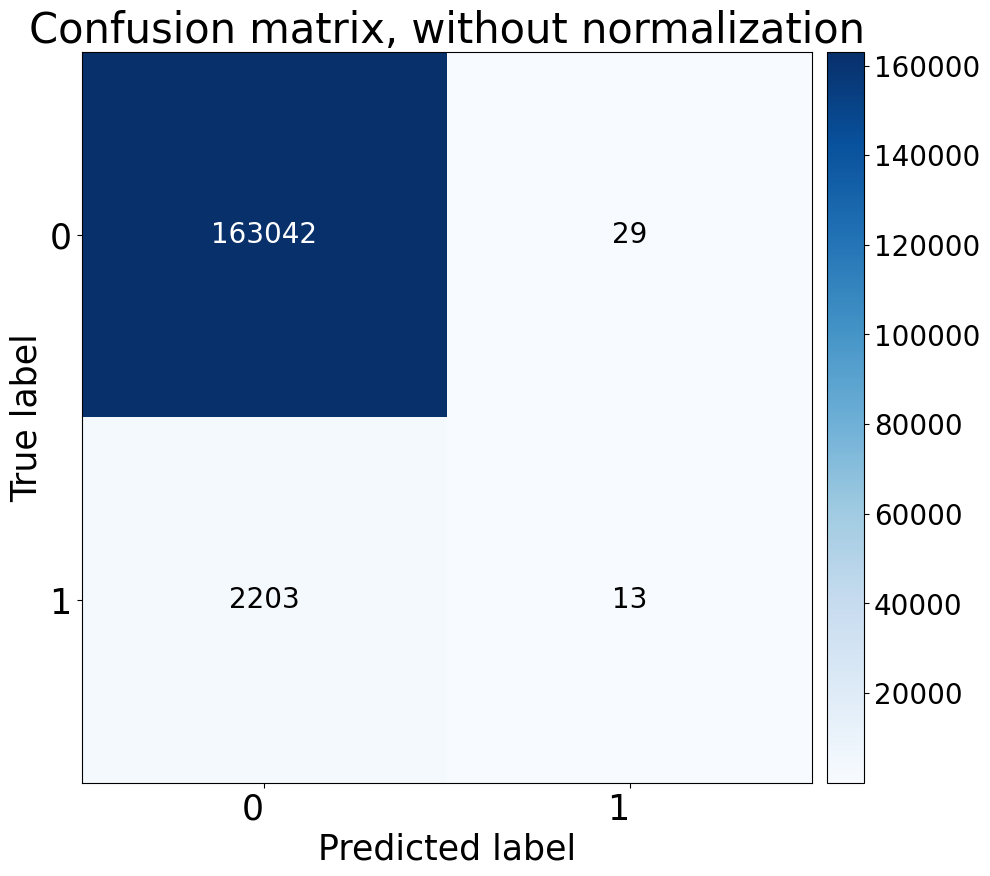

In [15]:
plot_confusion_matrix(
    y_test,
    y_pred,
    np.array(['0', '1']),
)